In [18]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import os
import time
# torch.manual_seed(seed=42) 
os.makedirs('./model_para', exist_ok=True)

In [19]:
class Mynetwork(nn.Module):
    def __init__(self,input_num=1 , out_num=1,hidden_num=128):
        super().__init__()
        self.MLP=nn.Sequential(
            nn.Linear(input_num, hidden_num),
            nn.ELU(),
            nn.Linear(hidden_num,hidden_num),
            nn.ELU(),
            nn.Linear(hidden_num,hidden_num),
            nn.ELU(),       
            nn.Linear(hidden_num,hidden_num),
            nn.ELU(),   
            nn.Linear(hidden_num,out_num),
        )
        pass
    def forward(self,x):
        return self.MLP(100-x)

In [20]:
def potential(x,k,l,scale=100):
    # poten=-1/x*scale
    # return poten-k*(l+1)*l/x**2
    poten=-10/x-10*torch.sin(torch.pi*x/24)/x
    return poten

In [21]:
#需要适当减小,x_M=sqrt(h_bar/(m*w)*(2n+1)),考虑要>10x_M,700sqrt(h_bar/\omega*m)
h_bar=1
m=1
b_lap:float=-h_bar**2/(2*m)

# 同时对于库伦势函数, 取e=1, 4\pi\epsilon_0=1, E_n=-1/(2n^2)
dtype=torch.float32
device=torch.device("cuda:2" if torch.cuda.is_available() else "cpu")

La=0
Lb =100
L=Lb-La  # domain length
N = 4000   # number of interior points # 对时间成本来说几乎是平方量级
h :float= L / (N+1)
grid=torch.linspace(La,Lb,N+2,dtype=dtype,device=device)
grid=grid[1:-1].unsqueeze(-1)
# 角量子数
l=0
# 控制势函数的大小
scale=10

en_num=30
extend_num=10
epoch=200000
lr=0.01


In [22]:
diag = -2.0 / h**2 * torch.ones(N,device=device) * b_lap
off_diag = 1.0 / h**2 * torch.ones(N - 1,device=device) * b_lap

V_diag=potential(grid,b_lap,l,scale)
A = torch.diag(diag) + torch.diag(off_diag,diagonal=1) + torch.diag(off_diag, diagonal=-1)+torch.diag(V_diag.flatten())
eigenvalues= torch.linalg.eigvalsh(A)

real_en=eigenvalues[:en_num].detach()
print('initial eigenvalues check:')
print(eigenvalues[:en_num+extend_num])

initial eigenvalues check:
tensor([-5.0551e+01, -1.3759e+01, -6.8472e+00, -4.4070e+00, -3.2510e+00,
        -2.5857e+00, -2.1391e+00, -1.8014e+00, -1.5234e+00, -1.2848e+00,
        -1.0722e+00, -8.7943e-01, -7.0419e-01, -5.4242e-01, -3.9783e-01,
        -3.1259e-01, -2.6561e-01, -2.6173e-01, -2.1234e-01, -1.6620e-01,
        -1.4930e-01, -1.2218e-01, -8.1936e-02, -5.4660e-02, -5.2069e-02,
        -4.5128e-02, -1.4405e-02,  4.0138e-03,  1.3537e-02,  2.6757e-02,
         4.6240e-02,  6.7044e-02,  8.8982e-02,  1.1245e-01,  1.3746e-01,
         1.6365e-01,  1.9150e-01,  2.2076e-01,  2.5125e-01,  2.8285e-01],
       device='cuda:2')


In [23]:
model=Mynetwork().to(device=device,dtype=dtype)
optimizer=torch.optim.Adam(model.parameters(),lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,patience=80,threshold=1e-4)
loss_fn=nn.L1Loss()

loss_list=[]
init_time=time.time()
for i in range(epoch):
    optimizer.zero_grad()
    V_diag=model(grid)
    A = torch.diag(diag) + torch.diag(off_diag,diagonal=1) + torch.diag(off_diag, diagonal=-1)+torch.diag(V_diag.flatten())
    eigenvalues= torch.linalg.eigvalsh(A)
    
    output=eigenvalues[:en_num]
    loss=loss_fn(output,real_en)
    loss.backward()
    optimizer.step()
    
    loss_list.append(loss.item())
    if i%10==0:
        print(f'epoch:{i},loss:{loss},time:{time.time()-init_time},lr:{optimizer.param_groups[0]["lr"]}')
        print('\nepoch:',i)
        print(eigenvalues[:en_num])
        print(real_en)
    
    if (i+1)%100==0:torch.save(model.state_dict(),f'./model_para/model_para_{lr}.pth')
    scheduler.step(loss)
    if optimizer.param_groups[0]["lr"] <= 1.1e-8:break
    
final_loss=loss.item()
final_time=time.time()-init_time
final_epoch=i+1
print('terminal epoch: ',i+1)
torch.save(model.state_dict(),f'./model_para/model_para_{lr}.pth')


epoch:0,loss:3.553093433380127,time:0.1123359203338623,lr:0.01

epoch: 0
tensor([0.1276, 0.1476, 0.1674, 0.1860, 0.2035, 0.2215, 0.2415, 0.2623, 0.2842,
        0.3069, 0.3291, 0.3522, 0.3753, 0.3976, 0.4215, 0.4444, 0.4680, 0.4918,
        0.5150, 0.5384, 0.5616, 0.5848, 0.6080, 0.6311, 0.6542, 0.6775, 0.7010,
        0.7254, 0.7504, 0.7769], device='cuda:2', grad_fn=<SliceBackward0>)
tensor([-5.0551e+01, -1.3759e+01, -6.8472e+00, -4.4070e+00, -3.2510e+00,
        -2.5857e+00, -2.1391e+00, -1.8014e+00, -1.5234e+00, -1.2848e+00,
        -1.0722e+00, -8.7943e-01, -7.0419e-01, -5.4242e-01, -3.9783e-01,
        -3.1259e-01, -2.6561e-01, -2.6173e-01, -2.1234e-01, -1.6620e-01,
        -1.4930e-01, -1.2218e-01, -8.1936e-02, -5.4660e-02, -5.2069e-02,
        -4.5128e-02, -1.4405e-02,  4.0138e-03,  1.3537e-02,  2.6757e-02],
       device='cuda:2')
epoch:10,loss:2.6217830181121826,time:1.132664680480957,lr:0.01

epoch: 10
tensor([-1.7327, -1.6069, -1.4954, -1.3909, -1.2915, -1.1966, -1.1056, -1

In [24]:
# -1.5237e-01, -1.3085e-01, -1.2296e-01, -1.0179e-01, -7.9435e-02,
#         -5.6185e-02, -3.5326e-02, -1.0974e-02,  1.4396e-02,  4.2974e-02
# -1.2695e-01, -9.2922e-02, -5.8262e-02, -2.2549e-02,  1.4835e-02,
#          5.1943e-02,  9.0080e-02,  1.2834e-01,  1.6763e-01,  2.0718e-01

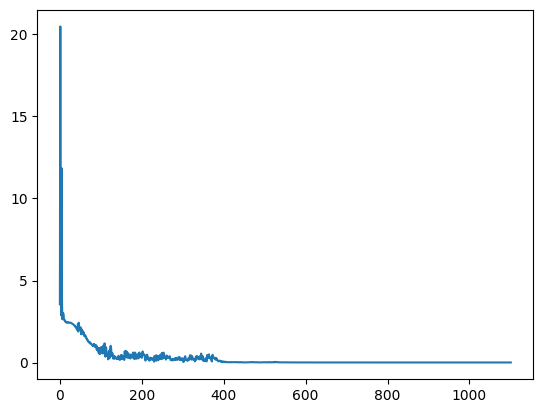

In [25]:
plt.plot(loss_list)
plt.show()

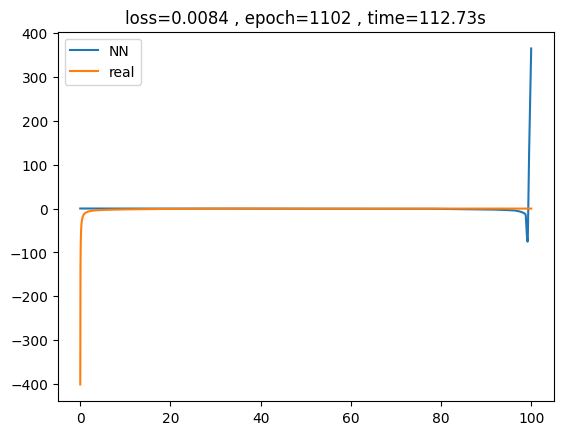

In [26]:
La=0
Lb =100
L=Lb-La  # domain length
N = 4000   # number of interior points # 对时间成本来说几乎是平方量级
h :float= L / (N+1)
grid=torch.linspace(La,Lb,N+2,dtype=dtype,device=device)
grid=grid[1:-1].unsqueeze(-1)
# grid=grid[100:]
NN_poten=model(grid)
real_poten=potential(grid,b_lap,l,scale)
NN_poten=NN_poten.cpu().detach().numpy()
real_poten=real_poten.cpu().detach().numpy()
grid=grid.cpu().detach().numpy()
plt.plot(grid,NN_poten
         ,label='NN')
plt.plot(grid,real_poten,label='real')
plt.title(f'loss={final_loss:.4f} , epoch={final_epoch} , time={final_time:.2f}s')
plt.legend()
plt.show()


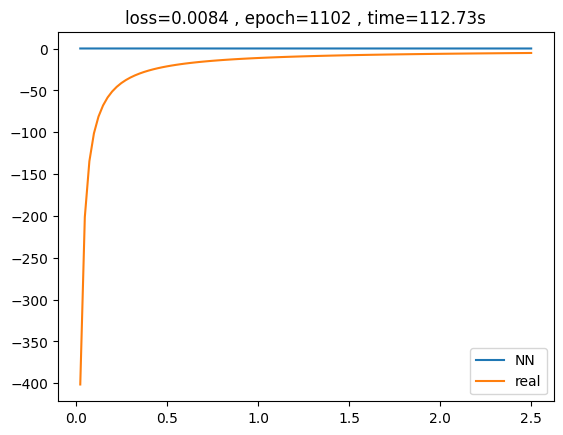

In [27]:
grid=torch.linspace(La,Lb,N+2,dtype=dtype,device=device)
grid=grid[1:-1].unsqueeze(-1)
grid=grid[:100]
NN_poten=model(grid)
real_poten=potential(grid,b_lap,l,scale)
NN_poten=NN_poten.cpu().detach().numpy()
real_poten=real_poten.cpu().detach().numpy()
grid=grid.cpu().detach().numpy()
plt.plot(grid,NN_poten,label='NN')
plt.plot(grid,real_poten,label='real')
plt.title(f'loss={final_loss:.4f} , epoch={final_epoch} , time={final_time:.2f}s')
plt.legend()
plt.show()

In [28]:
grid=torch.linspace(La,Lb,N+2,dtype=dtype,device=device)
grid=grid[1:-1].unsqueeze(-1)
V_diag=model(grid)
A = torch.diag(diag) + torch.diag(off_diag,diagonal=1) + torch.diag(off_diag, diagonal=-1)+torch.diag(V_diag.flatten())
eigenvalues= torch.linalg.eigvalsh(A)
output=eigenvalues[:en_num]

error=output-real_en
rela_error=error/real_en
print('final error:',error)
print('relative error:',rela_error)

final error: tensor([ 2.5940e-04,  3.7003e-04,  1.6260e-04,  8.2016e-05,  1.3828e-04,
        -3.2681e-02,  8.4262e-03,  9.8977e-03,  1.2016e-04, -6.2697e-03,
        -9.1267e-03, -7.5604e-03, -5.8413e-06,  1.0740e-02,  1.9054e-02,
         7.8480e-03, -9.7632e-05,  2.9217e-02,  9.4422e-03, -9.1629e-03,
         4.3258e-05, -3.0266e-03, -1.9736e-02, -2.4203e-02, -4.8084e-03,
         9.4930e-03, -5.6119e-04,  1.0535e-03,  1.1038e-02,  1.7091e-02],
       device='cuda:2', grad_fn=<SubBackward0>)
relative error: tensor([-5.1314e-06, -2.6893e-05, -2.3747e-05, -1.8610e-05, -4.2536e-05,
         1.2639e-02, -3.9391e-03, -5.4944e-03, -7.8880e-05,  4.8799e-03,
         8.5122e-03,  8.5970e-03,  8.2950e-06, -1.9800e-02, -4.7894e-02,
        -2.5107e-02,  3.6758e-04, -1.1163e-01, -4.4468e-02,  5.5133e-02,
        -2.8973e-04,  2.4771e-02,  2.4087e-01,  4.4279e-01,  9.2348e-02,
        -2.1036e-01,  3.8959e-02,  2.6248e-01,  8.1543e-01,  6.3873e-01],
       device='cuda:2', grad_fn=<DivBackward0

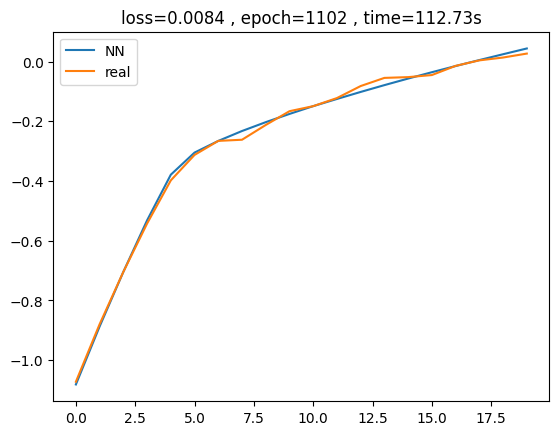

In [31]:
plt.plot(output[10:].detach().cpu().numpy(),label='NN')
plt.plot(real_en[10:].detach().cpu().numpy(),label='real')
plt.title(f'loss={final_loss:.4f} , epoch={final_epoch} , time={final_time:.2f}s')
plt.legend()
plt.show()

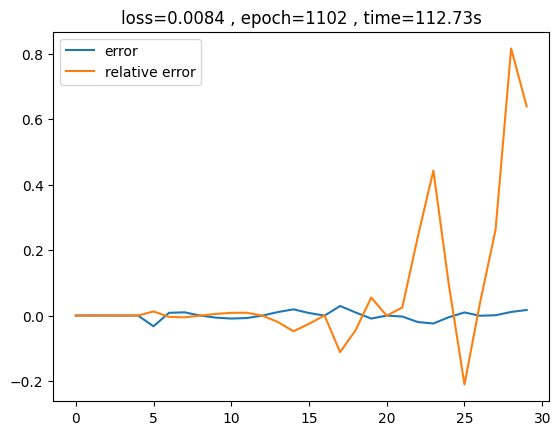

In [30]:
plt.plot(error.detach().cpu().numpy(),label='error')
plt.plot(rela_error.detach().cpu().numpy(),label='relative error')
plt.title(f'loss={final_loss:.4f} , epoch={final_epoch} , time={final_time:.2f}s')
plt.legend()
plt.show()